# Dahlin Tutorial + Palantir

First part implements Dahlin tutorial described here: 
    https://gottgens-lab.stemcells.cam.ac.uk/adultHSPC10X/html_links/notebook_dahlin_analysis_scanpy_0pt4pt2.html

Second part takes the corrected data and integrates with the Palantir toolkit for pseudotime and differentiation potential analysis.

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
from scanpy import utils
import re
import collections
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

/Users/mcfefa/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
sc.settings.savefigs = False

In [4]:
mpl.rcParams['figure.figsize'] = [4.0, 4.0]
mpl.rcParams['grid.alpha'] = 0.0

In [5]:
sc.logging.print_version_and_date()
sc.logging.print_versions()

Running Scanpy 1.4.4, on 2020-09-14 13:48.
scanpy==1.4.4 anndata==0.6.22.post1 umap==0.3.7 numpy==1.16.2 scipy==1.3.1 pandas==0.23.4 scikit-learn==0.20.3 statsmodels==0.10.1


## Analysis of WT LSK + LK data

#### Quality Control

First read in the wild-type combined LSK and LK data data

filtered_gene_bc_expression_wt.mtx - the CellRanger output matrices from processing the six WT samples separately were merged into single .mtx file containing raw counts for barcodes that passed the default CellRanger filtering. Rows correspond to cells and columns to genes

genes_wt.tsv - contains the ensembl IDs labelling the genes in each column of the counts matrix

gene_names_wt.tsv - contains the gene names labelling the genes in each column of the counts matrix

barcodes_wt.tsv - contains the cell barcodes labelling the cells in each row of the counts matrix

In [6]:
filedir = '/Volumes/lab_padron/Meghan/scRNAseq/Palantir_cell-fate/mouse/Dahlin-Corrected/Notebook_input_data/'
figdir = '/Volumes/lab_padron/Meghan/scRNAseq/Palantir_cell-fate/mouse/Dahlin-Corrected/results/'
sampleID = 'Dahlin_TutorialPrep' 
date = '2020-09-14'

In [7]:
filename_data = 'filtered_gene_bc_expression_wt.mtx'
filename_gene_ids = 'genes_wt.tsv'
filename_gene_names = 'gene_names_wt.tsv'
filename_barcodes = 'barcodes_wt.tsv'

In [8]:
# Load WT data
adata_wt = sc.read(filedir+filename_data, cache=True).transpose()
adata_wt.var_names = np.loadtxt(filedir+filename_gene_names, dtype='str')
adata_wt.var['ensembl_ids'] = np.loadtxt(filedir+filename_gene_ids, dtype='str')
adata_wt.obs_names = np.loadtxt(filedir+filename_barcodes, dtype='str')

adata_wt.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


6 samples 10X samples were run across the same shared 8 sequencing lanes. Samples {SIGAB1, SIGAC1, SIGAD1} are fr
om the Lin- Sca1+ Kit+ (LSK) sorting gate and samples {SIGAF1, SIGAG1, SIGAH1} are from the Lin- Kit+ (LK) sorting gate.

In [9]:
# Add the sorting gate information
group_names = ['LK', 'LSK']
cell_groups = [str.split(cellname, '_')[1] for cellname in adata_wt.obs_names]
adata_wt.obs['sample'] = cell_groups
adata_wt.obs['exp_groups'] = ['LSK' if group in ('SIGAB1', 'SIGAC1', 'SIGAD1') else 'LK' for group in cell_groups] 

To identify potential doublets in the data each cell was scored using the method of Wollock et al. 2018. This was run separately on each sample and the results stored in the files doublet_scores_SIGAX1.txt. Here we load these results and filter cells based on their doublet scores.

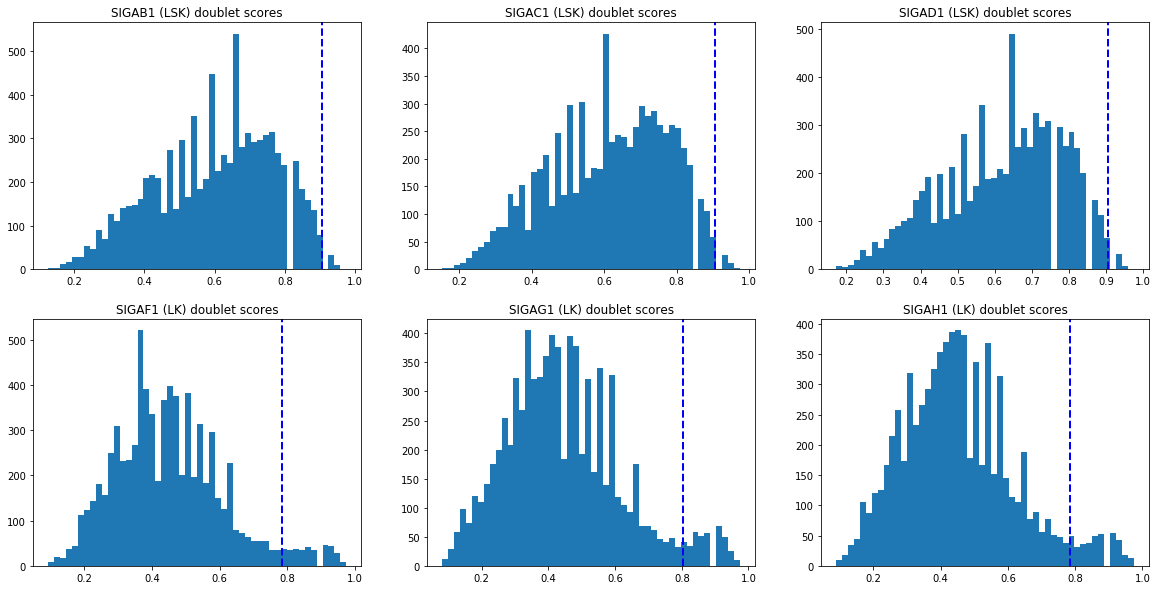

Removing 1452 cells due to doublet scoring


In [10]:
sample_barcodes = ['SIGAB1', 'SIGAC1', 'SIGAD1', 'SIGAF1', 'SIGAG1', 'SIGAH1']
sample_types = {'SIGAB1': 'LSK', 'SIGAC1': 'LSK', 'SIGAD1': 'LSK',
               'SIGAF1': 'LK', 'SIGAG1': 'LK', 'SIGAH1': 'LK'}

# Plot histograms
plt.figure(figsize=(20,10))

doublet_scores_filter = []
for i, sample_barcode in enumerate(sample_barcodes):
    
    # Read in pre-computed doublet scores
    doublet_scores_file = filedir+'doublet_scores_' + sample_barcode + '.txt'
    doublet_scores_sample = pd.read_csv(doublet_scores_file, names=['score'])
    
    # Set the cutoff dependent on sample type
    sample_type = sample_types[sample_barcode]
    threshold = 1.0 if sample_type == 'LSK' else 4.5
    cutoff = np.percentile(doublet_scores_sample['score'], 100-threshold)
    
    # Plot histograms of doublet scores with thresholds for samples
    plt.subplot(2,3,i+1)
    plt.hist(doublet_scores_sample['score'], bins=50)
    plt.axvline(cutoff, color='b', linestyle='dashed', linewidth=2)
    plt.title('%s (%s) doublet scores' %(sample_barcode, sample_type))
    
    # Make mask for filtering
    doublet_scores_filter_sample = np.array(doublet_scores_sample['score']) < cutoff
    doublet_scores_filter += list(doublet_scores_filter_sample)

plt.show()

# Filter the cells based on doublet score
print('Removing %d cells due to doublet scoring' %(len(doublet_scores_filter) - sum(doublet_scores_filter)))
adata_wt = adata_wt[np.array(doublet_scores_filter), :]

Now basic quality control filtering to remove genes/cells based on the following criteria:

Remove genes expressed in fewer than 3 cells
Remove cells with more than 10% mitochondrial reads
Remove cells with outlying number of UMI counts per cell (outside the range of mean  ±  3  ×  standard deviation)
Remove cells expressing fewer than 500 genes

In [11]:
# Calculate mitochondrial gene content
mito_genes = np.array([name for name in adata_wt.var_names if bool(re.search("mt-", name))])

# for each cell compute fraction of counts in mito genes vs. all genes
adata_wt.obs['percent_mito'] = np.sum(adata_wt[:, mito_genes].X, axis=1).A1 / np.sum(adata_wt.X, axis=1).A1

# add the total counts per cell as sample annotation to adata
adata_wt.obs['n_counts'] = np.sum(adata_wt.X, axis=1).A1
adata_wt.obs['n_counts_log'] = np.log10(np.sum(adata_wt.X, axis=1).A1)

# Calculate mean and standard deviation for filtering
sd_counts = np.std(adata_wt.obs['n_counts_log'])
mean_counts = np.mean(adata_wt.obs['n_counts_log'])

# Filter cells with counts outside mean ± 3s.d.
max_counts_filter = mean_counts + 3*sd_counts
min_counts_filter = mean_counts - 3*sd_counts
counts_filter = np.logical_and(adata_wt.obs['n_counts_log'] >= min_counts_filter,
                               adata_wt.obs['n_counts_log'] <= max_counts_filter)

print('%d cells with extreme counts filtered' % (adata_wt.X.shape[0] - np.sum(counts_filter)))
print("filtered %d cells with more than 10 percent mitochondrial reads" %(sum(adata_wt.obs['percent_mito'] >= 0.1)))

adata_wt = adata_wt[np.logical_and(adata_wt.obs['percent_mito'] < 0.1, counts_filter), :]
sc.pp.filter_cells(adata_wt, min_genes=500)

# Save object with all genes for W41 cluster mapping
adata_wt_all_genes = adata_wt.copy()
sc.pp.filter_genes(adata_wt, min_cells=3)

Trying to set attribute `.obs` of view, making a copy.


69 cells with extreme counts filtered
filtered 81 cells with more than 10 percent mitochondrial reads


Trying to set attribute `.obs` of view, making a copy.


In [12]:
# See how many cells and genes left after filtering
nCells = adata_wt.X.shape[0]
nGenes = adata_wt.X.shape[1]
print('Data has', nGenes, 'genes in', nCells, 'cells')

Data has 17633 genes in 44802 cells


#### Normalization 

In [13]:
sc.pp.normalize_total(adata_wt, target_sum=1e4)

In [14]:
adata_wt_LK = adata_wt.copy()
adata_wt_LK = sc.AnnData(adata_wt_LK[np.array([group == 'LK' for group in adata_wt_LK.obs['exp_groups']]), :].copy())

#### Identify highly variable genes

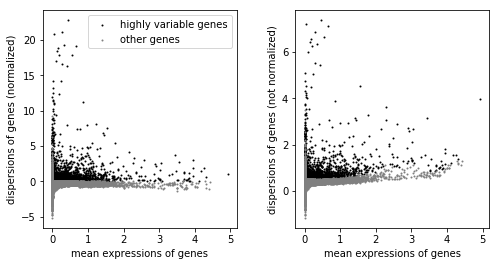

In [15]:
# All cells
result = sc.pp.filter_genes_dispersion(adata_wt.X, log=True, flavor='seurat', 
                                       min_mean=0.001, max_mean=5, min_disp=0.05, copy=True)
sc.pl.filter_genes_dispersion(result)
adata_wt = adata_wt[:, result.gene_subset].copy()

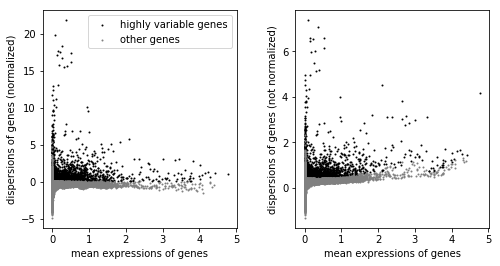

In [16]:
# Just LK
result_LK = sc.pp.filter_genes_dispersion(adata_wt_LK.X, log=True, flavor='seurat', 
                                       min_mean=0.001, max_mean=5, min_disp=0.05, copy=True)
sc.pl.filter_genes_dispersion(result_LK)
adata_wt_LK = adata_wt_LK[:, result_LK.gene_subset].copy()

#### Dimensionality reduction

In [17]:
# Colormap for plotting
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred'])

PCA

In [18]:
# All cells
sc.pp.normalize_total(adata_wt)
sc.pp.log1p(adata_wt)  # log transform: X = log(X + 1)
adata_wt.raw = adata_wt ### per documentation here: https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html
sc.pp.scale(adata_wt)
sc.tl.pca(adata_wt, n_comps=50)

In [19]:
# LK
sc.pp.normalize_total(adata_wt_LK)
sc.pp.log1p(adata_wt_LK)  # log transform: X = log(X + 1)
adata_wt_LK.raw = adata_wt_LK
sc.pp.scale(adata_wt_LK)
sc.tl.pca(adata_wt_LK, n_comps=50)

... storing 'sample' as categorical
... storing 'exp_groups' as categorical


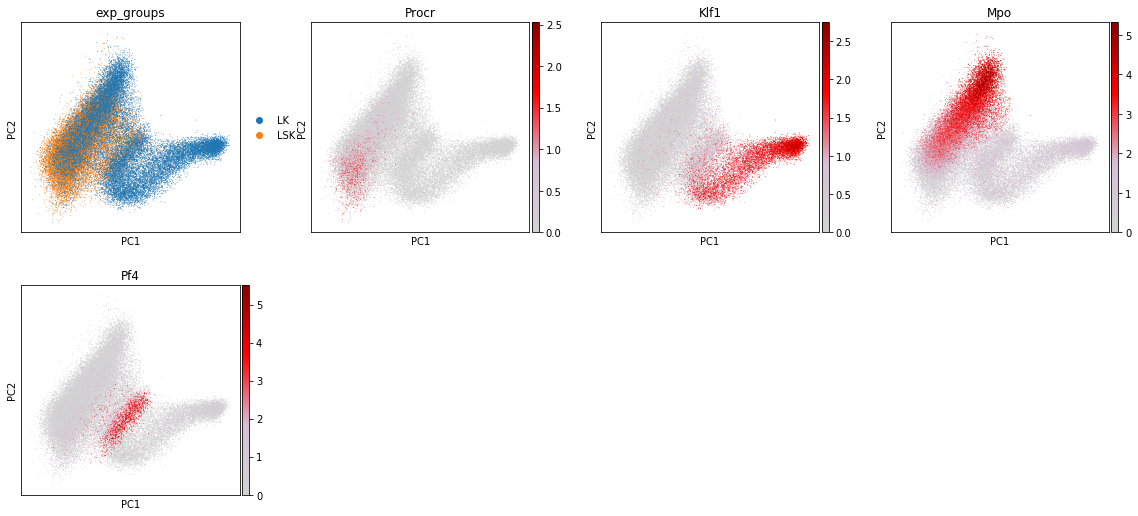

... storing 'sample' as categorical
... storing 'exp_groups' as categorical


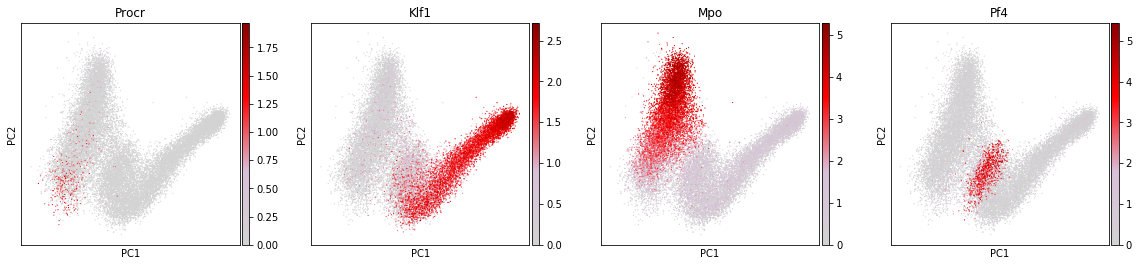

In [20]:
# Plot
sc.pl.pca_scatter(adata_wt, color=['exp_groups', 'Procr', 'Klf1', 'Mpo', 'Pf4'], color_map=cmap)
sc.pl.pca_scatter(adata_wt_LK, color=['Procr', 'Klf1', 'Mpo', 'Pf4'], color_map=cmap)

Calculate diffusion map

In [21]:
# Calculating diffusion map, after calculating a nearest neighbor graph 

# All cells
sc.pp.neighbors(adata_wt)
sc.tl.diffmap(adata_wt)

# LK cells
sc.pp.neighbors(adata_wt_LK)
sc.tl.diffmap(adata_wt_LK)

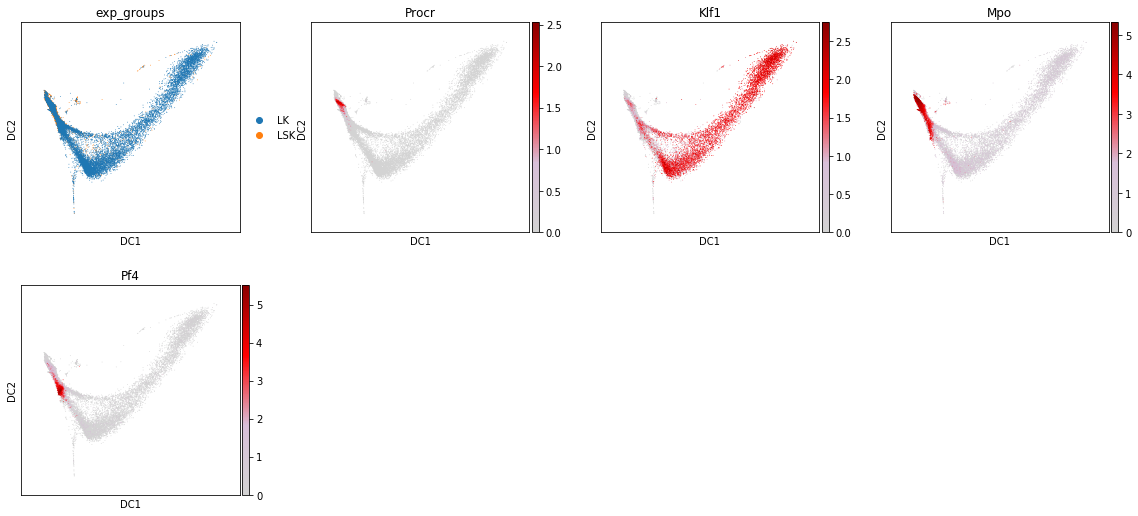

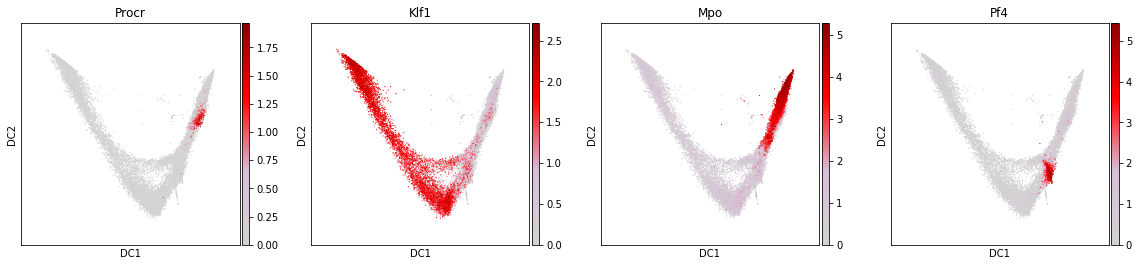

In [22]:
# Plot
sc.pl.diffmap(adata_wt, color=['exp_groups', 'Procr', 'Klf1', 'Mpo', 'Pf4'], color_map=cmap)
sc.pl.diffmap(adata_wt_LK, color=['Procr', 'Klf1', 'Mpo', 'Pf4'], color_map=cmap)

#### Identifying and removing cell cycle effect

In diffusion map can see strange loop shape. Looking into this a bit further, can see this is in erythroid lineage (from expression of marker genes such as Klf4).

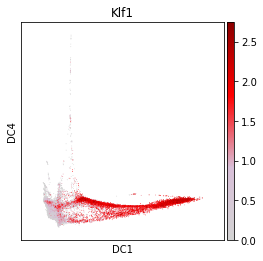

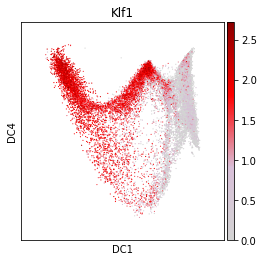

In [23]:
sc.pl.diffmap(adata_wt, color=['Klf1'], components=['1,4'], show=True, color_map=cmap)
sc.pl.diffmap(adata_wt_LK, color=['Klf1'], components=['1,4'], show=True, color_map=cmap)

Isolate cells on both side of 'loop' to perform differential expression and work out what is causing separation.

Note: Might need to change the thresholds by a factor of -1 if the diffusion coordinates are reflected.

In [24]:
# All cells
erythroid_group = np.array(['none' for i in range(adata_wt.X.shape[0])], dtype=pd.Categorical)
erythroid_group[np.logical_and(np.logical_and(adata_wt.obsm['X_diffmap'][:, 0] > -0.015,
                                              adata_wt.obsm['X_diffmap'][:, 3] > 0.002),
                               adata_wt.obsm['X_diffmap'][:, 0] < -0.0025)] = 'ery_1'
erythroid_group[np.logical_and(np.logical_and(adata_wt.obsm['X_diffmap'][:, 0] > -0.015,
                                              adata_wt.obsm['X_diffmap'][:, 3] < -0.002),
                               adata_wt.obsm['X_diffmap'][:, 0] < -0.0025)] = 'ery_2'

... storing 'erythroid_cc_group' as categorical


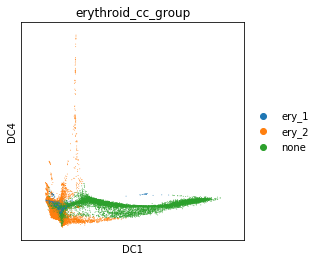

In [25]:
adata_wt.obs['erythroid_cc_group'] = erythroid_group
sc.pl.diffmap(adata_wt, color=['erythroid_cc_group'], components=['1,4'], show=True)

... storing 'erythroid_cc_group' as categorical


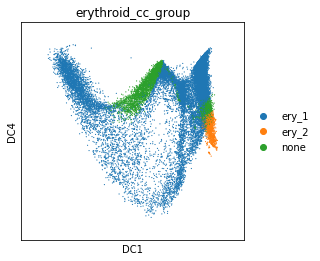

In [26]:
# LK cells
erythroid_group_LK = np.array(['none' for i in range(adata_wt_LK.X.shape[0])], dtype=pd.Categorical)
erythroid_group_LK[np.logical_and(np.logical_and(adata_wt_LK.obsm['X_diffmap'][:, 0] < 0.012,
                                              adata_wt_LK.obsm['X_diffmap'][:, 3] < 0.005),
                               adata_wt_LK.obsm['X_diffmap'][:, 0] > 0)] = 'ery_1'
erythroid_group_LK[np.logical_and(np.logical_and(adata_wt_LK.obsm['X_diffmap'][:, 0] < 0.012,
                                              adata_wt_LK.obsm['X_diffmap'][:, 3] > 0.01),
                               adata_wt_LK.obsm['X_diffmap'][:, 0] > 0)] = 'ery_2'
adata_wt_LK.obs['erythroid_cc_group'] = erythroid_group_LK
sc.pl.diffmap(adata_wt_LK, color=['erythroid_cc_group'], components=['1,4'], show=True)

Differential expression between groups 1 and 2

In [27]:
# All cells
adata_erythroid = adata_wt[adata_wt.obs['erythroid_cc_group'] != 'none', :]
sc.tl.rank_genes_groups(adata_erythroid, 'erythroid_cc_group', n_genes=50, verbose=True)

de_genes_1 = [x[0] for x in adata_erythroid.uns['rank_genes_groups']['names']]
de_genes_2 = [x[1] for x in adata_erythroid.uns['rank_genes_groups']['names']]

In [28]:
# LK cells
adata_erythroid_LK = adata_wt_LK[adata_wt_LK.obs['erythroid_cc_group'] != 'none', :]
sc.tl.rank_genes_groups(adata_erythroid_LK, 'erythroid_cc_group', n_genes=350)

de_genes_1_LK = [x[0] for x in adata_erythroid_LK.uns['rank_genes_groups']['names']]
de_genes_2_LK = [x[1] for x in adata_erythroid_LK.uns['rank_genes_groups']['names']]

Gene ontology analysis of these genes reveals significant cell cycle terms. So identify cell cycle related genes in this set to remove from further analysis.

In [29]:
# Load cell cycle genes
cell_cycle_genes_file = filedir+'mouse_cell_cycle_genes.txt'
with open(cell_cycle_genes_file) as f: 
    cell_cycle_genes = [line.strip('\n') for line in f.readlines()]
    
# Use genes differentially expressed between two groups 
de_erythroid_genes = de_genes_1 + de_genes_2
de_erythroid_genes_LK = de_genes_1_LK + de_genes_2_LK
    
de_erythroid_cell_cycle = list(set(cell_cycle_genes) & set(de_erythroid_genes))
print("%d cell cycle genes in erythroid set" %len(de_erythroid_cell_cycle))

de_erythroid_cell_cycle_LK = list(set(cell_cycle_genes) & set(de_erythroid_genes_LK))
print("%d cell cycle genes in erythroid set for LK cells" %len(de_erythroid_cell_cycle_LK))

17 cell cycle genes in erythroid set
14 cell cycle genes in erythroid set for LK cells


In [30]:
# Identify genes correlating with cell cycle genes and remove
# All cells
gene_correlation = np.corrcoef(adata_wt.X.transpose())
gene_correlation_cell_cycle = gene_correlation[
    [i for i, gene in enumerate(adata_wt.var_names) if gene in cell_cycle_genes], :]

cutoff = 0.5 # originally was 0.2

high_correlation_gene_filter = np.amax(gene_correlation_cell_cycle, axis=0) < cutoff
cell_cycle_removed_genes = adata_wt.var_names[np.invert(high_correlation_gene_filter)]

adata_wt_no_cc = adata_wt[:, high_correlation_gene_filter]

# LK cells
gene_correlation_LK = np.corrcoef(adata_wt_LK.X.transpose())
gene_correlation_cell_cycle_LK = gene_correlation_LK[
    [i for i, gene in enumerate(adata_wt_LK.var_names) if gene in cell_cycle_genes], :]

high_correlation_gene_filter_LK = np.amax(gene_correlation_cell_cycle_LK, axis=0) < cutoff
cell_cycle_removed_genes_LK = adata_wt_LK.var_names[np.invert(high_correlation_gene_filter_LK)]

adata_wt_LK_no_cc = adata_wt_LK[:, high_correlation_gene_filter_LK]

In [31]:
gene_correlation_cell_cycle.max()

1.0

#### Recompute dimensionality reduction on the dataset with cell cycle genes removed


PCA and diffusion map. From diffusion map can see that the cell cycle separation is fixed.

In [32]:
# All cells
sc.tl.pca(adata_wt_no_cc)
sc.tl.diffmap(adata_wt_no_cc)

# LK cells
sc.tl.pca(adata_wt_LK_no_cc)
sc.tl.diffmap(adata_wt_LK_no_cc)

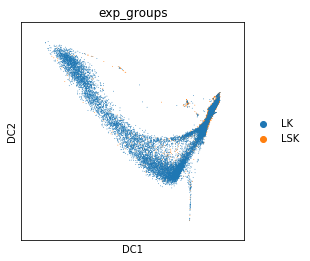

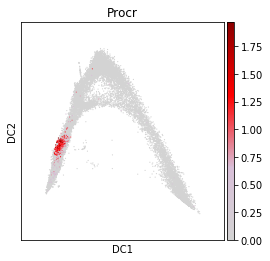

In [33]:
sc.pl.diffmap(adata_wt_no_cc, color='exp_groups')
sc.pl.diffmap(adata_wt_LK_no_cc, color='Procr', color_map=cmap)

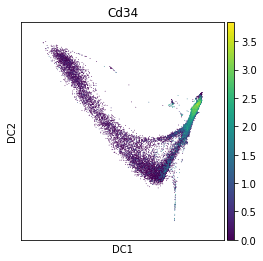

In [34]:
sc.pl.diffmap(adata_wt_no_cc, color='Cd34')

#### Force directed graph visualisation

Force directed graph coordinates were calculated using Gephi where the input for a dataset was a k=7 knn graph constructed on the cell cycle gene filtered dataset of highly variable genes. Here, we read in these precomputed coordinates for visualisation.

In [35]:
# All cells
wt_coordinates = pd.read_csv(filedir+'wt_gephi_coordinates.csv', index_col=0)
wt_coordinates = wt_coordinates.loc[adata_wt_no_cc.obs_names]

In [36]:
# Add gephi coordinates
adata_wt_no_cc.obs['gephi_1'] = wt_coordinates['x']
adata_wt_no_cc.obs['gephi_2'] = wt_coordinates['y']

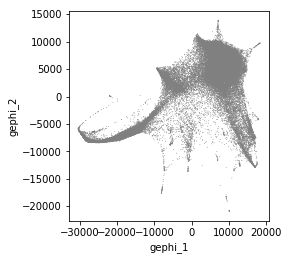

In [37]:
# Plot ,   color=['exp_groups','Ms4a2', 'Procr', 'Itga2b'],
sc.pl.scatter(adata_wt_no_cc, x='gephi_1', y='gephi_2', color_map=cmap)

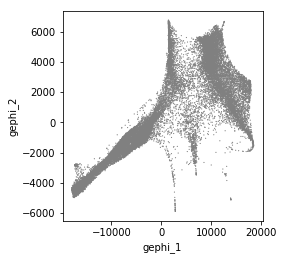

In [38]:
# LK cells
wt_LK_coordinates = pd.read_csv(filedir+'wt_LK_gephi_coordinates.csv', index_col=0)
wt_LK_coordinates = wt_LK_coordinates.loc[adata_wt_LK_no_cc.obs_names]

# Add gephi coordinates
adata_wt_LK_no_cc.obs['gephi_1'] = wt_LK_coordinates['x']
adata_wt_LK_no_cc.obs['gephi_2'] = wt_LK_coordinates['y']

# Plot
sc.pl.scatter(adata_wt_LK_no_cc, x='gephi_1', y='gephi_2', color_map=cmap)
              #  color=['Ms4a2','Procr','Itga2b'],

In [39]:
tmp = adata_wt_no_cc[adata_wt_no_cc.obs['exp_groups']=='LSK',:]

In [40]:
adata_wt_no_cc_LSKonly = tmp.copy()

## PALANTIR

In [41]:
import sys
import palantir
import os
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use
import pickle
import pandas as pd
import numpy as np
from MulticoreTSNE import MulticoreTSNE as TSNE
import matplotlib
from matplotlib import font_manager

In [42]:
filedir = '/Volumes/lab_padron/Meghan/scRNAseq/Palantir_cell-fate/mouse/Dahlin-Corrected/Notebook_input_data/'
figdir = '/Volumes/lab_padron/Meghan/scRNAseq/Palantir_cell-fate/mouse/Dahlin-Corrected/results/'
sampleID = 'Dahlin_TutorialPrep' 
date = '2020-09-14'

In [43]:
palantir_dir = os.path.expanduser('/Users/mcfefa/Palantir')

#### Harvest information previously calculated in the Dahlin tutorial

In [48]:
## dataset of interest is the LSK population: adata_wt_no_cc_LSKonly
## creating the count matrix into a pandas dataframe that can be utilized by Palantir

rownames = adata_wt_no_cc_LSKonly.obs.index;
colnames = adata_wt_no_cc_LSKonly.var.index;
expMtxAsDF = pd.DataFrame(adata_wt_no_cc_LSKonly.X, columns=colnames, index=rownames)
counts = expMtxAsDF;

In [53]:
## data has already been through quality control/normalization steps, so can use this to definte normalized dataframe
norm_df = counts

##### instead of tSNE embeddings, used Gephi embeddings from Dahlin tutorial

In [54]:
gephiDeh = {'x': adata_wt_no_cc_LSKonly.obs['gephi_1'], 'y': adata_wt_no_cc_LSKonly.obs['gephi_2']}
gephi_Dahlin = pd.DataFrame(data=gephiDeh, index=adata_wt_no_cc_LSKonly.obs['gephi_1'].index)

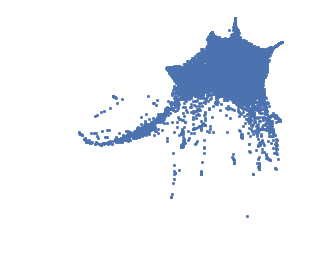

In [55]:
fig, ax = palantir.plot.plot_tsne(gephiDeh)
fig = plt.gcf()
fig

In [56]:
## using pca_projections previously calculated in Dahlin tutorial 
pca_projects_Dahlin = pd.DataFrame(data=adata_wt_no_cc_LSKonly.obsm['X_pca'], index=adata_wt_no_cc_LSKonly.obs['sample'].index)

In [57]:
## picking up Palantir tutorial here to determines the diffusion maps of the data as an estimate of the low dimensional phenotypic manifold of the data. the eigen gap using the following function
dm_res_fromDahlinPCA = palantir.utils.run_diffusion_maps(pca_projects_Dahlin, n_components=15)

Determing nearest neighbor graph...


In [58]:
ms_data_fromDahlinPCA = palantir.utils.determine_multiscale_space(dm_res_fromDahlinPCA, n_eigs=15)

#### MAGIC imputation of dataset

In [60]:
import magic
import scprep

In [61]:
imp_df_fromDahlinPCA = palantir.utils.run_magic_imputation(expMtxAsDF, dm_res_fromDahlinPCA)

In [65]:
## human hematopoietic markers 
hemeGeneList = ['Malat1','Creb1','Cd34','Tal1','Gata2',
                'Gata1','Spi1','Egr1','Irf8',
                'Cebpa','Elane','Jun','Tcf7','Ebf1',
                'Mpo','Cd79b','Itga2b']
## not observed in experiment: 'Csf1r','Klf1',

In [70]:
%matplotlib inline

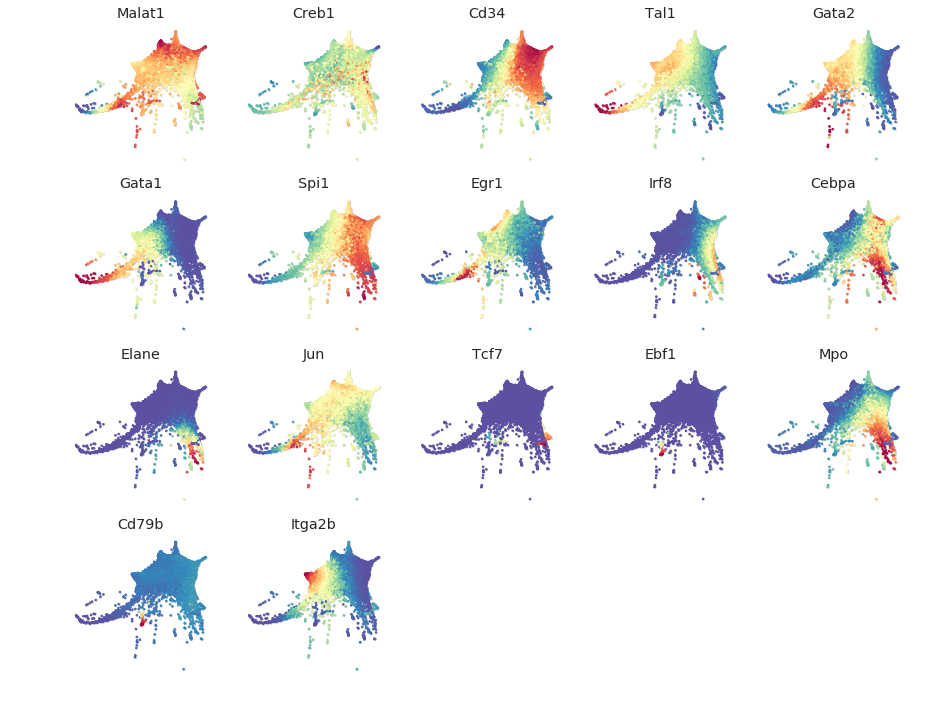

In [71]:
palantir.plot.plot_gene_expression(imp_df_fromDahlinPCA, gephi_Dahlin, hemeGeneList)
fig = plt.gcf()

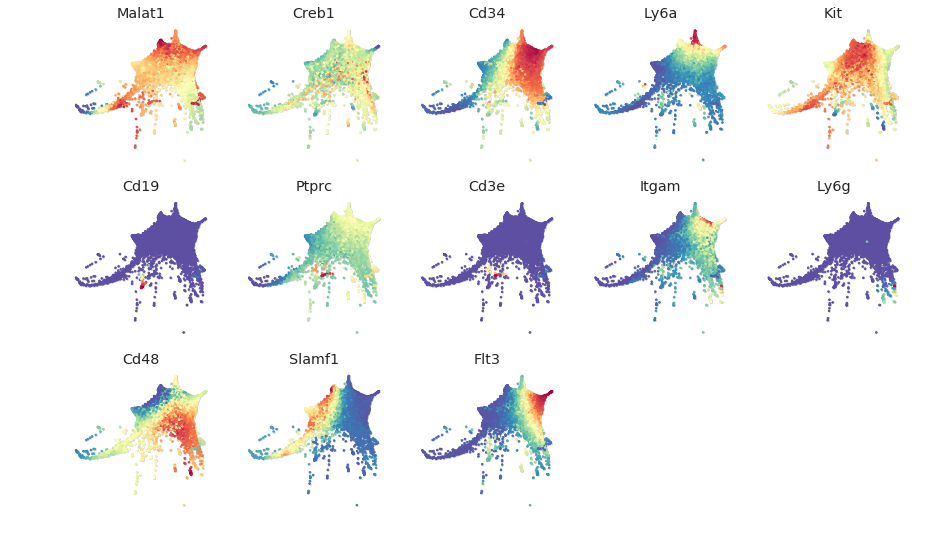

In [72]:
### mouse hematopoietic markers
# mhemeGeneList = ['Malat1','Creb1','Cd34','Sca1','Ckit',
#                'Cd19','B220','Cd3e','Cd11b','Gr1',
#                'Cd48','Cd150','Cd135']

## cKit -> Kit
## Sca1 -> Ly6a
## CD11b -> Itgam
## B220 -> Ptprc
## Gr1 -> Ly6g
## Cd150 -> Slamf1
## Cd135 -> Flt3

mhemeGeneList = ['Malat1','Creb1','Cd34','Ly6a','Kit','Cd19','Ptprc','Cd3e','Itgam','Ly6g','Cd48','Slamf1','Flt3']

palantir.plot.plot_gene_expression(imp_df_fromDahlinPCA, gephi_Dahlin, mhemeGeneList)

saving individual plots with color bars

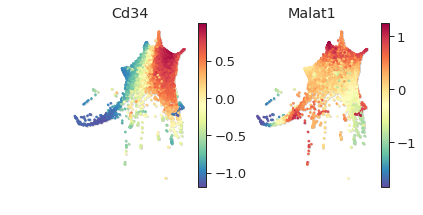

In [74]:
palantir.plot.plot_gene_expression(imp_df_fromDahlinPCA, gephi_Dahlin, ['Cd34','Malat1'],plot_scale=True)
fig = plt.gcf()
fig.savefig('./DahlinCCExampleMice_MAGIC-Imputation_KeyGenesOfInterest_CD34+MALAT1_2020-09-14.png', dpi=600)

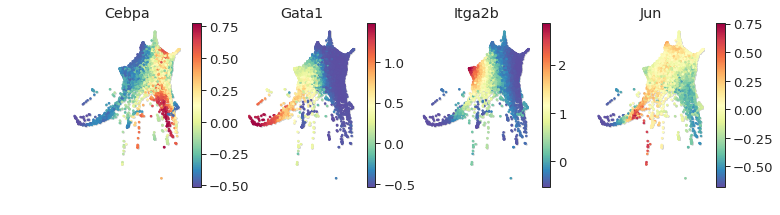

In [75]:
palantir.plot.plot_gene_expression(imp_df_fromDahlinPCA, gephi_Dahlin, ['Cebpa','Gata1','Itga2b','Jun'],plot_scale=True)
fig = plt.gcf()
fig.savefig('./DahlinCCExampleMice_MAGIC-Imputation_KeyGenesOfInterest_CEBPA+GATA1+ITGA2B+JUN_2020-09-14.png', dpi=600)

In [76]:
## pickling data here to save all important variables so far
file_path_out = figdir+sampleID+'_post-MAGIC-ImputeDF+GephiEmbeddings_'+date+'.pickle'
n_bytes = 2**31
max_bytes = 2**31 -1
data = bytearray(n_bytes)

bytes_out = pickle.dumps([expMtxAsDF, imp_df_fromDahlinPCA, pca_projects_Dahlin, dm_res_fromDahlinPCA, ms_data_fromDahlinPCA, gephi_Dahlin], protocol=4)
with open(file_path_out, 'wb') as f_out: 
    for idx in range(0, len(bytes_out), max_bytes):
        f_out.write(bytes_out[idx:idx+max_bytes])

### Palantir: Pseudotime & Differential Potential

##### Step 1: Identifying Start and Terminal States

In [77]:
start_cell = imp_df_fromDahlinPCA[['Cd34']].idxmax()[0]

visualizing starting cell on the Gephi embeddings

(<Figure size 288x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x122acd0f0>)

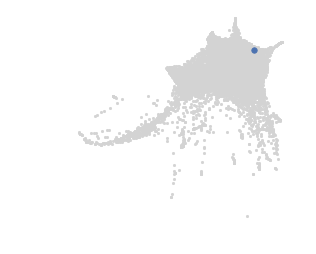

In [78]:
palantir.plot.highlight_cells_on_tsne(gephi_Dahlin, start_cell)

In [79]:
term1 = imp_df_fromDahlinPCA[['Itga2b']].idxmax()[0]
term2 = imp_df_fromDahlinPCA[['Gata1']].idxmax()[0]
term3 = imp_df_fromDahlinPCA[['Ebf1']].idxmax()[0]
term4 = imp_df_fromDahlinPCA[['Mpo']].idxmax()[0]

visualizing terminal states on the Gephi embeddings

(<Figure size 288x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1635bc208>)

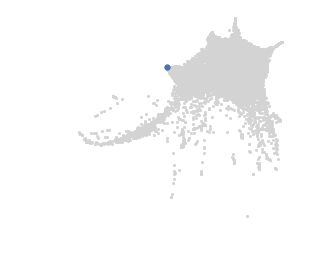

In [80]:
palantir.plot.highlight_cells_on_tsne(gephi_Dahlin, term1)

(<Figure size 288x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12880f0b8>)

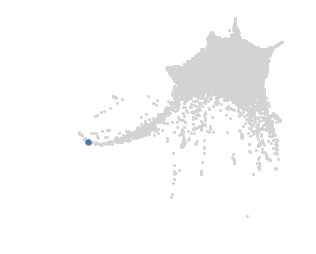

In [81]:
palantir.plot.highlight_cells_on_tsne(gephi_Dahlin, term2)

(<Figure size 288x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x124601da0>)

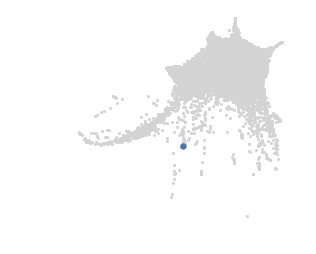

In [82]:
palantir.plot.highlight_cells_on_tsne(gephi_Dahlin, term3)

(<Figure size 288x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13b216c50>)

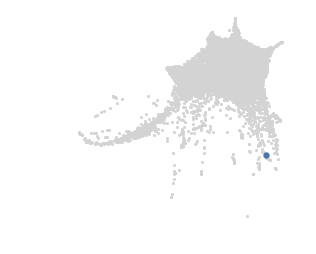

In [83]:
palantir.plot.highlight_cells_on_tsne(gephi_Dahlin, term4)

#### Step 2: Running Palantir

In [84]:
term_cells = [term1, term2, term3, term4]

In [85]:
##### per methods section of paper: 
## Palantir was applied to each replicate separately using 1,200 waypoints and 1 of the CD34+ cells as the start cell. 
## The parameter k was set to 10% of the total number of cells in the data. 
## The number of diffusion components was chosen based on the eigengap of the eigenvector decomposition of the diffusion operator. 
## The results are stable to the choice of number of diffusion components and the choice of waypoints 

pr_res = palantir.core.run_palantir(ms_data_fromDahlinPCA, start_cell, terminal_states=term_cells, num_waypoints=1200)

Sampling and flocking waypoints...
Time for determining waypoints: 0.04042915105819702 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 1.0070716698964437 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9941
Correlation at iteration 2: 0.9997
Correlation at iteration 3: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


In [86]:
pr_res.branch_probs.columns

Index(['AGCGTCGTCAGGCAAG-1_SIGAB1', 'GCATACAAGCCATCGC-1_SIGAB1',
       'GGACAGAGTAGCGTAG-1_SIGAB1', 'GGTGCGTGTTCCATGA-1_SIGAC1'],
      dtype='object')

In [87]:
mapping = pd.Series(index=['Gata1max', 'Itga2bmax', 'Mpomax', 'Ebf1max'])
mapping['Gata1max'] = gephi_Dahlin.loc[pr_res.branch_probs.columns, 'x'].idxmin()
mapping['Itga2bmax'] = gephi_Dahlin.loc[pr_res.branch_probs.columns, 'y'].idxmax()
mapping['Mpomax'] = gephi_Dahlin.loc[pr_res.branch_probs.columns, 'x'].idxmax()
mapping['Ebf1max'] = pr_res.branch_probs.columns.difference(mapping.values)[0]
mapping = pd.Series(mapping.index, index=mapping)

In [88]:
pr_res.branch_probs.columns = mapping[pr_res.branch_probs.columns]
pr_res.branch_probs = pr_res.branch_probs.loc[:, ['Gata1max', 'Itga2bmax', 'Mpomax', 'Ebf1max']]

#### Visualizing Palantir Results

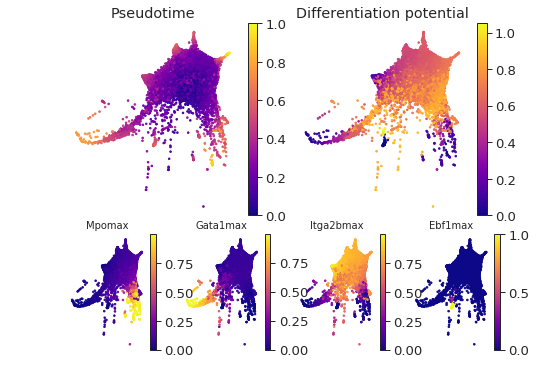

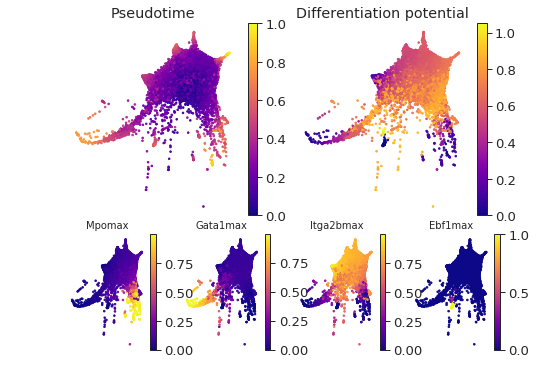

In [89]:
palantir.plot.plot_palantir_results(pr_res, gephi_Dahlin)
fig = plt.gcf()
fig

In [90]:
file_palantir = figdir+sampleID+'_PalantirRes_Gephi_'+date+'.pdf'
palantir.plot.plot_palantir_results(pr_res, gephi_Dahlin)
fig = plt.gcf()
fig.savefig(file_palantir)
matplotlib.pyplot.close(fig='all')

#### Pickle all Palantir variables, in case needed later

In [91]:
file_path_out = figdir+sampleID+'_postPalantirRes_Gephi'+date+'.pickle'
n_bytes = 2**31
max_bytes = 2**31 -1
data = bytearray(n_bytes)

bytes_out = pickle.dumps([start_cell, term_cells, pr_res, mapping], protocol=4)
with open(file_path_out, 'wb') as f_out: 
    for idx in range(0, len(bytes_out), max_bytes):
        f_out.write(bytes_out[idx:idx+max_bytes])